# Instacart Analysis: Part 1
This notebook covers Part 1 of Exercise 4.10 for the Instacart project.

# 📑 Table of Contents

1️⃣ Introduction & Setup  
2️⃣ Regional Segmentation  
3️⃣ Excluding Low-Activity Customers  
4️⃣ Customer Profiling  
5️⃣ Profile Distribution  
6️⃣ Spending Analysis by Region  
7️⃣ Profile vs. Region Analysis  
8️⃣ Profile vs. Department Analysis  
9️⃣ Profile Aggregation  
🔟 Export Final Data


In [2]:

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set the path to your main project folder
path = r'C:\Users\rhysm\OneDrive\Desktop\Career Foundry\Data Immersion\Module 4\04-2025 Instacart Basket Analysis'

# Import the prepared dataframe
ords_prods_cust_merge = pd.read_pickle(os.path.join(
    path, '02 Data', 'Prepared Data', 'ords_prods_cust_merge.pkl'))


We import the main libraries:

- `pandas`, `numpy`, and `os` for data handling.
- `matplotlib.pyplot` and `seaborn` for data visualization.

We also load the prepared merged dataframe (`ords_prods_cust_merge.pkl`) to begin analysis.


In [3]:

# --- Regional Segmentation ---
region_mapping = {
    'Northeast': ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut',
                  'New York', 'New Jersey', 'Pennsylvania'],
    'Midwest': ['Ohio', 'Michigan', 'Indiana', 'Wisconsin', 'Illinois', 'Minnesota', 'Iowa', 'Missouri',
                'North Dakota', 'South Dakota', 'Nebraska', 'Kansas'],
    'South': ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia', 'North Carolina',
              'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama',
              'Oklahoma', 'Texas', 'Arkansas', 'Louisiana'],
    'West': ['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico',
             'Alaska', 'Washington', 'Oregon', 'California', 'Hawaii']
}

def assign_region(state):
    for region, states in region_mapping.items():
        if state in states:
            return region
    return 'Other'

ords_prods_cust_merge['Region'] = ords_prods_cust_merge['STATE'].apply(assign_region)


We define a `region_mapping` dictionary that groups U.S. states into four major regions: Northeast, Midwest, South, and West. This is used to categorize customers based on their state into a broader region for regional analysis.


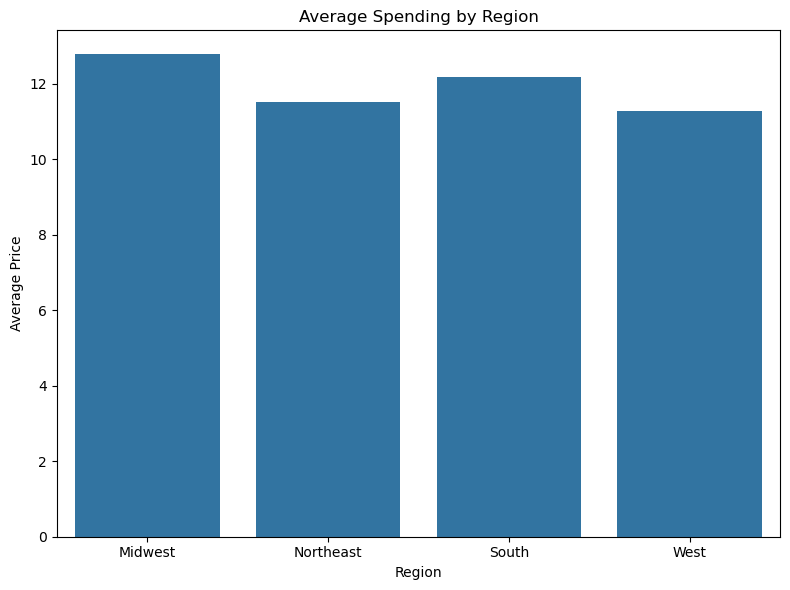

In [4]:

# --- Spending Habits by Region ---
region_spend = ords_prods_cust_merge.groupby('Region')['prices'].mean().reset_index()
plt.figure(figsize=(8,6))
sns.barplot(data=region_spend, x='Region', y='prices')
plt.title('Average Spending by Region')
plt.xlabel('Region')
plt.ylabel('Average Price')
plt.tight_layout()
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'avg_spending_by_region.png'))
plt.show()


We create a function `assign_region()` to assign each customer to their corresponding region based on the `STATE` column. Then we:

- Add a new `Region` column.
- Group the data by `Region` to calculate **average spending**.
- Visualize average spending per region using a bar chart.
- Save the chart as `avg_spending_by_region.png`.


In [5]:

# --- Exclude Low-Activity Customers ---
ords_prods_cust_merge['exclusion_flag'] = np.where(ords_prods_cust_merge['order_number'] < 5, 'Exclude', 'Include')
filtered_data = ords_prods_cust_merge[ords_prods_cust_merge['exclusion_flag'] == 'Include']


In [6]:

# --- Customer Profiling ---
def profile(row):
    if row['n_dependants'] >= 3:
        return 'Large family'
    elif row['n_dependants'] == 0 and row['Age'] < 30:
        return 'Young single'
    elif row['n_dependants'] >= 1 and row['Age'] < 40:
        return 'Young parent'
    elif row['income'] > 100000:
        return 'Affluent'
    else:
        return 'Other'

filtered_data.loc[:, 'profile'] = filtered_data.apply(profile, axis=1)


C:\Users\rhysm\AppData\Local\Temp\ipykernel_12768\3674121012.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'profile'] = filtered_data.apply(profile, axis=1)


We define a `profile()` function to classify customers into profiles based on:

- Number of dependents.
- Age.
- Income.

The profiles include: 'Large family', 'Young single', 'Young parent', 'Affluent', and 'Other'. We apply this function to the data to create a new `profile` column.


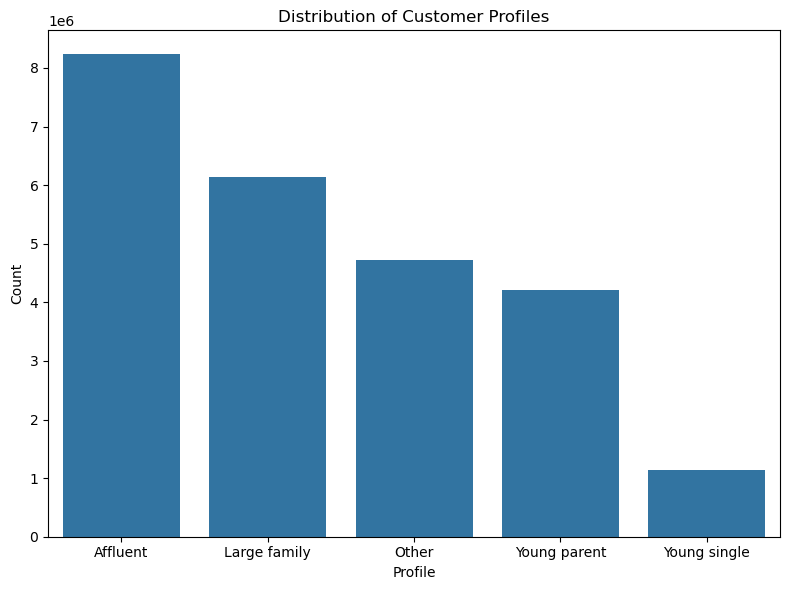

In [7]:

# --- Profile Distribution ---
plt.figure(figsize=(8,6))
sns.countplot(data=filtered_data, x='profile', order=filtered_data['profile'].value_counts().index)
plt.title('Distribution of Customer Profiles')
plt.xlabel('Profile')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'profile_distribution.png'))
plt.show()


We create a **countplot** to visualize how many customers fall into each profile category. This gives a quick overview of the distribution of customer profiles and is saved as `profile_distribution.png`.


In [8]:

# --- Aggregation by Profile ---
profile_agg = filtered_data.groupby('profile').agg({
    'order_number': ['max', 'mean', 'min'],
    'prices': ['max', 'mean', 'min']
})
print(profile_agg)


             order_number                  prices                
                      max       mean min      max       mean  min
profile                                                          
Affluent               99  22.046275   5  99999.0  13.952391  1.0
Large family           99  21.936572   5  99999.0  11.470183  1.0
Other                  99  21.859046   5  99999.0   8.025344  1.0
Young parent           99  21.926360   5  99999.0  12.197317  1.0
Young single           99  21.781358   5  99999.0  12.818824  1.0


We aggregate key statistics for each profile:

- `order_number`: max, mean, min.
- `prices`: max, mean, min.

This helps us understand shopping behavior by profile, such as how many orders they place and their spending range.


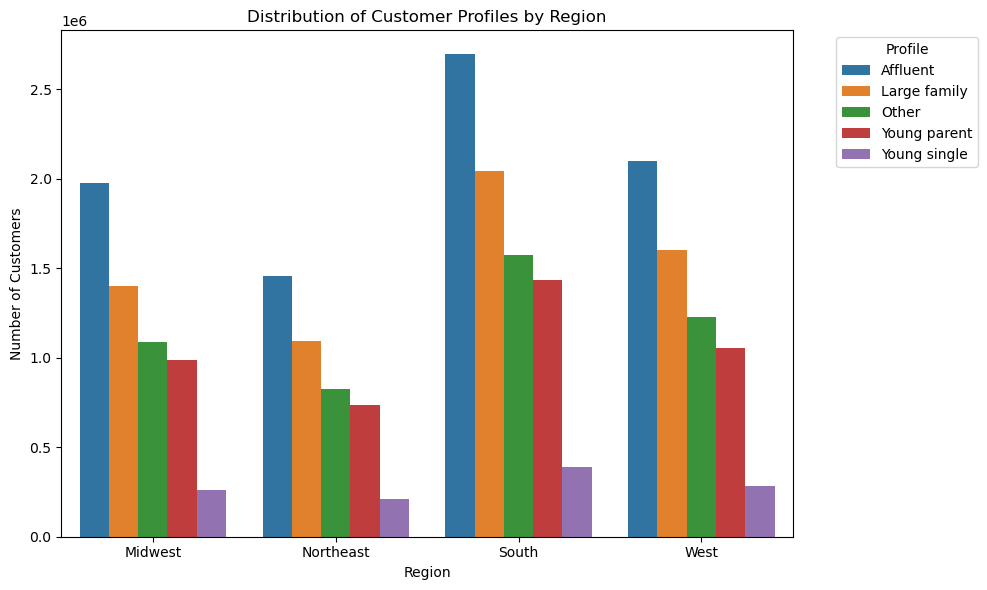

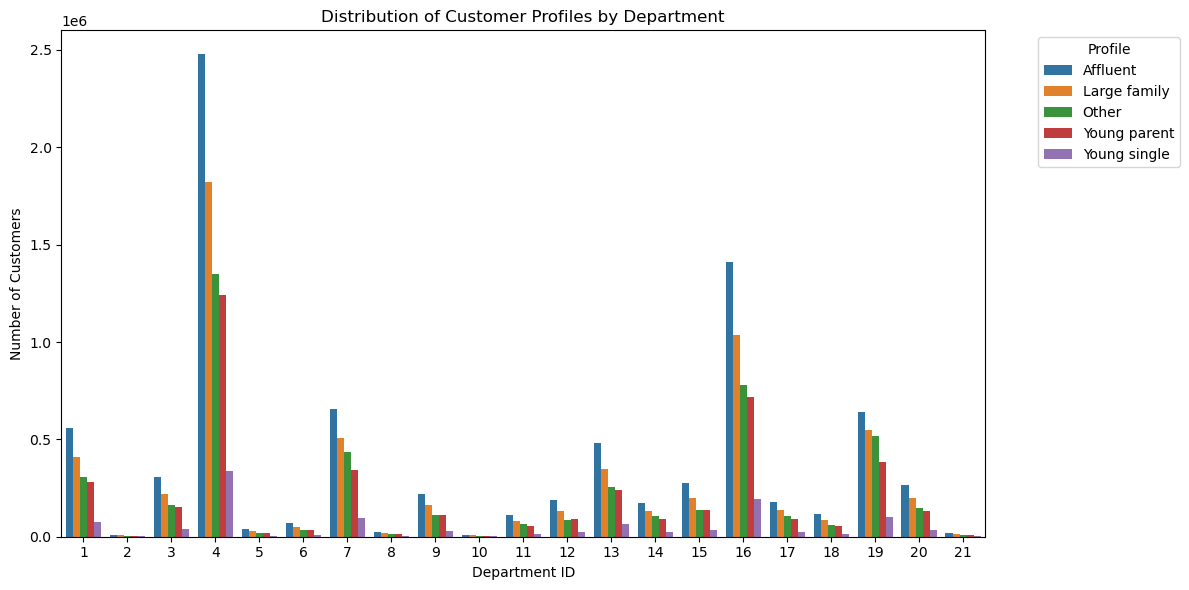

In [9]:

# --- Regional and Department Comparison ---
region_profile = pd.crosstab(filtered_data['Region'], filtered_data['profile'], normalize='index')

# Chart: Region vs Profile
region_profile_counts = filtered_data.groupby(['Region', 'profile']).size().reset_index(name='counts')
plt.figure(figsize=(10,6))
sns.barplot(data=region_profile_counts, x='Region', y='counts', hue='profile')
plt.title('Distribution of Customer Profiles by Region')
plt.xlabel('Region')
plt.ylabel('Number of Customers')
plt.legend(title='Profile', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'profile_by_region.png'))
plt.show()

# Chart: Department vs Profile
dept_profile_counts = filtered_data.groupby(['department_id', 'profile']).size().reset_index(name='counts')
plt.figure(figsize=(12,6))
sns.barplot(data=dept_profile_counts, x='department_id', y='counts', hue='profile')
plt.title('Distribution of Customer Profiles by Department')
plt.xlabel('Department ID')
plt.ylabel('Number of Customers')
plt.legend(title='Profile', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'profile_by_department.png'))
plt.show()


We create two grouped bar charts:

1️⃣ **Region vs Profile:**
   - Counts how many customers of each profile exist per region.
   - Visualizes it and saves as `profile_by_region.png`.

2️⃣ **Department vs Profile:**
   - Counts how many customers of each profile shop in each department.
   - Visualizes it and saves as `profile_by_department.png`.

These charts show how customer profiles are distributed across both regions and departments.


In [17]:

# --- Export Final Data ---
filtered_data.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'ords_prods_cust_merge_final.pkl'))


We export the final version of the filtered and enriched dataset (`ords_prods_cust_merge_final.pkl`) for future use. This file contains all the new columns (Region, profile, exclusion_flag, etc.).
